# Selection and cleaning of the Data Set

This is part of section XX in the book chapter "Book Chapter".

The statistics shown here intend to enlighten the characteristics of the data set used to contruct the ABM.

The data was provided by the PMMG, to whom we are very thankful.

The **programmer** is Eric Araujo.

The **last update** was in 12/09/2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import geopandas
import descartes
import numpy as np

import folium
import seaborn as sns

%matplotlib inline

/Users/eric/Documents/CrimAI/code/Python/.venv/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/eric/Documents/CrimAI/code/Python/.venv/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
xls = pd.ExcelFile('data/Lavras.xls')
registers = pd.read_excel(xls, 'OCORRENCIAS')
involved = pd.read_excel(xls, 'ENVOLVIDOS')
#materials = pd.read_excel(xls, 'MATERIAIS')

In [3]:
registers.head(2)

,Ano Fato,Bairro,Desc Longa Meio Utilizado,Desc Longa Subgrupo Complemento Nat,Descrição Longa Local Imediato,Descrição Subclasse Nat Principal,Dia da Semana Fato,Dia Numérico Fato,Faixa 1 Hora Fato,Latitude,Longitude,Mês Numérico Fato,Município,Número REDS,Tentado/Consumado Nat Principal,UNIDADE_AREA,Unidade Área Militar,Município - Código
0,2014,ANISIO ALVES DE ABREU,AGRESSAO FISICA SEM EMPREGO DE INSTRUMENTOS,BENS / VALORES DE ESTABELECIMENTO /PESSOA JURI...,POSTO DE COMBUSTIVEL,ROUBO,QUARTA-FEIRA,8,De 03:00 as 03:59,-21.254166,-44.999031,1,LAVRAS,2014-000525047-001,TENTADO,08 BPM,54 CIA PM/8 BPM/6 RPM,313820
1,2014,ANISIO ALVES DE ABREU,ARMAS DE FOGO,BENS / VALORES DE ESTABELECIMENTO /PESSOA JURI...,POSTO DE COMBUSTIVEL,ROUBO,QUARTA-FEIRA,29,De 00:00 as 00:59,-21.254166,-44.999031,1,LAVRAS,2014-002172720-001,CONSUMADO,08 BPM,54 CIA PM/8 BPM/6 RPM,313820


In [4]:
involved.head(2)

,Número REDS,Tipo Envolvimento,Idade Aparente,Cútis,Deficiência Física,Estado Civil,Grau Lesão,Escolaridade,Prisão / Apreensão,Sexo,Ocupação Atual,Nacionalidade
0,2014-000053870-001,VITIMA DE ACAO CRIMINAL / CIVEL,43.0,PARDA,PREENCHIMENTO OPCIONAL,CASADO,SEM LESOES APARENTES,ENSINO MEDIO COMPLETO (2º GRAU),PREENCHIMENTO OPCIONAL,MASCULINO,NaN,BRASILEIRA
1,2014-000143918-001,VITIMA DE ACAO CRIMINAL / CIVEL,22.0,NEGRA,PREENCHIMENTO OPCIONAL,SOLTEIRO,SEM LESOES APARENTES,ENSINO FUNDAMENTAL COMPLETO (8 ANOS ESTUDO),PREENCHIMENTO OPCIONAL,MASCULINO,NaN,BRASILEIRA


## Structuring and selecting data for registers

In [5]:
# Renaming registers columns
translate_cols = {'Ano Fato': 'year',
                  'Mês Numérico Fato': 'month',
                  'Dia Numérico Fato': 'day',
                  'Dia da Semana Fato': 'week_day',
                  'Bairro': 'neighborhood',
                  'Desc Longa Meio Utilizado': 'violence_type',
                  'Desc Longa Subgrupo Complemento Nat': 'type_object_robbed',
                  'Descrição Longa Local Imediato': 'location_description',
                  'Descrição Subclasse Nat Principal': 'crime_type',
                  'Faixa 1 Hora Fato': 'one_h_window',
                  'Latitude': 'lat',
                  'Longitude': 'lon',
                  'Município': 'city',
                  'Número REDS': 'reds',
                  'Tentado/Consumado Nat Principal': 'committed',
                  'UNIDADE_AREA': 'pm_area',
                  'Unidade Área Militar': 'pm_unity', 
                  'Município - Código': 'city_code'
                 }
registers.rename(columns=translate_cols, inplace=True)

# Removing irrelevant columns for registers
registers = registers[['year', 'neighborhood', 'violence_type', 'type_object_robbed',
       'location_description', 'crime_type', 'week_day', 'day',
       'one_h_window', 'lat', 'lon', 'month', 'city', 'reds', 'committed',
       ]]

# Selecting data from the years (2014-2018)
registers = registers[registers.year.isin([2014,2015,2016,2017,2018])]

# Removing white spaces in one_h_window column
registers.one_h_window = registers.one_h_window.str.rstrip()


# Changing time windows
one_h_replacement_dict = {   'De 00:00 as 00:59': '00:00 - 00:59',
                             'De 01:00 as 01:59': '01:00 - 01:59',
                             'De 02:00 as 02:59': '02:00 - 02:59',
                             'De 03:00 as 03:59': '03:00 - 03:59',
                             'De 04:00 as 04:59': '04:00 - 04:59',
                             'De 05:00 as 05:59': '05:00 - 05:59',
                             'De 06:00 as 06:59': '06:00 - 06:59',
                             'De 07:00 as 07:59': '07:00 - 07:59',
                             'De 08:00 as 08:59': '08:00 - 08:59',
                             'De 09:00 as 09:59': '09:00 - 09:59',
                             'De 10:00 as 10:59': '10:00 - 10:59',
                             'De 11:00 as 11:59': '11:00 - 11:59',
                             'De 12:00 as 12:59': '12:00 - 12:59',
                             'De 13:00 as 13:59': '13:00 - 13:59',
                             'De 14:00 as 14:59': '14:00 - 14:59',
                             'De 15:00 as 15:59': '15:00 - 15:59',
                             'De 16:00 as 16:59': '16:00 - 16:59',
                             'De 17:00 as 17:59': '17:00 - 17:59',
                             'De 18:00 as 18:59': '18:00 - 18:59',
                             'De 19:00 as 19:59': '19:00 - 19:59',
                             'De 20:00 as 20:59': '20:00 - 20:59',
                             'De 21:00 as 21:59': '21:00 - 21:59',
                             'De 22:00 as 22:59': '22:00 - 22:59',
                             'De 23:00 as 23:59': '23:00 - 23:59'}

registers.one_h_window.replace(one_h_replacement_dict, inplace=True)

# Input NaN to missing values in the data set
missing_values = ['INVÁLIDO', 'ESCOLARIDADE - IGNORADA', 'IGNORADA', 'PREENCHIMENTO OPCIONAL', 'INVALIDO', 
                  'ESTADO CIVIL - IGNORADO', 'ESTADO CIVIL - NAO DECLARADO', 'PREENCHIMENTO OPCIONAL', 
                  'GRAU DA LESAO - IGNORADO' ]
registers.replace(to_replace=missing_values, value=np.nan, inplace=True)

In [6]:
# No duplicates
print('Number of registers in the file: \t', len(registers))
print('Number of unique REDS - IDs: \t\t', len(set(registers.reds)))

Number of registers in the file: 	 862
Number of unique REDS - IDs: 		 862


Text(0.5, 1, 'Missing Data')

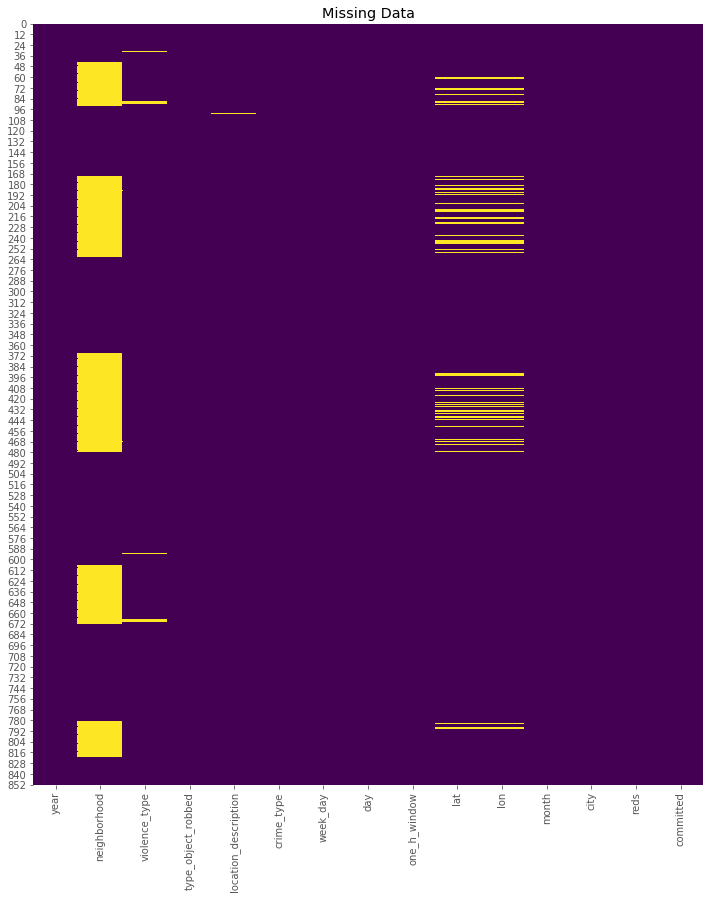

In [7]:
plt.figure(figsize=(12,14))
sns.heatmap(registers.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Data')

In [8]:
miss_amount = len(registers[(pd.isna(registers.lat)) | (pd.isna(registers.lon))])
print('Registers without lat or lon: \t', miss_amount)
print('Total registers: \t\t', len(registers))
print('Percentage of missing data: \t', miss_amount*100/len(registers), '%')

Registers without lat or lon: 	 59
Total registers: 		 862
Percentage of missing data: 	 6.844547563805104 %


In [9]:
registers.dropna(axis=0, subset=['lat', 'lon'], inplace=True)
len(registers)

803

In [10]:
# Location description
pd.value_counts(registers.location_description)[:10]

VIA DE ACESSO PUBLICA                              407
POSTO DE COMBUSTIVEL                               113
BAR / LANCHONETE / RESTAURANTE / SIMILAR            62
OUTROS - ESTABELECIMENTOS COMERCIAIS / SERVICOS     29
CASA                                                29
MERCEARIA / SACOLAO / SUPERMERCADO                  27
CONFEITARIA / PADARIA / PANIFICADORA                24
LOJA DIVERSA                                        16
SITIO                                               12
BOATE / CASA DE SHOW / SIMILAR                      11
Name: location_description, dtype: int64

In [11]:
407/803

0.5068493150684932

In [12]:
# Select crimes on the streets and reset index
registers_streets = registers[registers.location_description=='VIA DE ACESSO PUBLICA']
registers_streets.reset_index(drop=True, inplace=True)

In [13]:
location_comparison_df = pd.DataFrame([registers.year.value_counts().sort_index(ascending=False), 
                                      registers_streets.year.value_counts().sort_index(ascending=False)], 
                                      index=['Total', 'Streets']).T

In [14]:
location_comparison_df

,Total,Streets
2018,121,66
2017,187,101
2016,221,104
2015,161,77
2014,113,59


In [15]:
location_comparison_df.sum()

Total      803
Streets    407
dtype: int64

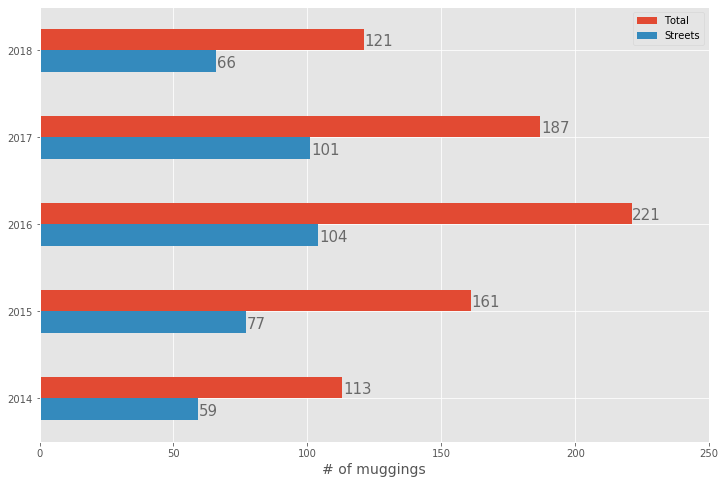

In [16]:
# Crimes per year
ax = location_comparison_df.plot(kind='barh', figsize=((12,8)))

ax.set_alpha(0.8)
#plt.title('Robberies per year in Lavras (2014-2018)', fontsize=18)
plt.xlabel('# of muggings', fontsize=14)
plt.xlim(0,250)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())
    #print(totals)
    
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.2, \
            str(round((i.get_width()), 2)), fontsize=15,
color='dimgrey')
# invert for largest on top 
ax.invert_yaxis()

## Selecting data within map limits

lower_x = -45.0059971

higher_x = -44.9870231

lower_y = -21.2479824

higher_y = -21.2360275

In [17]:
# Limits for lat and lon
# x
lower_lon = -45.0059971
higher_lon = -44.9870231
# y
lower_lat = -21.2479824
higher_lat = -21.2360275

In [18]:
# Selecting registers based on GIS limits
reg_streets_gis = registers_streets[(registers_streets.lat >= lower_lat) & (registers_streets.lat <= higher_lat) &
                                    (registers_streets.lon >= lower_lon) & (registers_streets.lon <= higher_lon)]
print('Registers of muggings in the streets within GIS limist: ', len(reg_streets_gis))

Registers of muggings in the streets within GIS limist:  113


In [19]:
mugggings_comparison_df = pd.DataFrame([registers.year.value_counts().sort_index(ascending=False), 
                                      registers_streets.year.value_counts().sort_index(ascending=False),
                                      reg_streets_gis.year.value_counts().sort_index(ascending=False)], 
                                      index=['Total', 'Streets', 'Streets + GIS limits']).T

In [20]:
mugggings_comparison_df

,Total,Streets,Streets + GIS limits
2018,121,66,14
2017,187,101,26
2016,221,104,31
2015,161,77,22
2014,113,59,20


In [21]:
mugggings_comparison_df.sum()

Total                   803
Streets                 407
Streets + GIS limits    113
dtype: int64

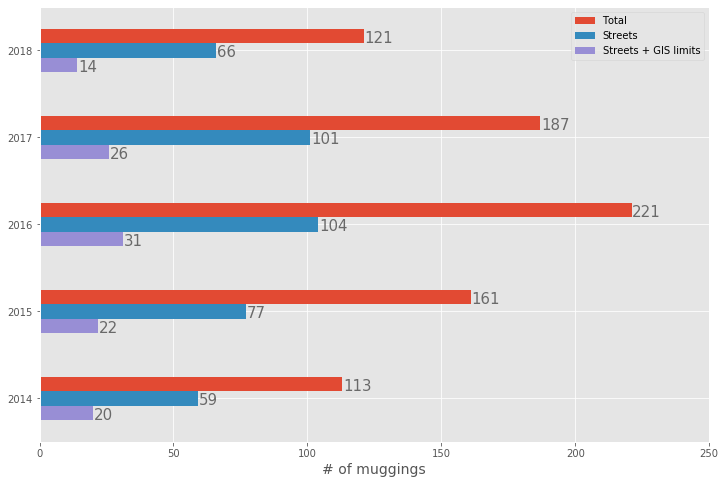

In [22]:
# Crimes per year
ax = mugggings_comparison_df.plot(kind='barh', figsize=((12,8)))

ax.set_alpha(0.8)
#plt.title('Robberies per year in Lavras (2014-2018)', fontsize=18)
plt.xlabel('# of muggings', fontsize=14)
plt.xlim(0,250)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())
    #print(totals)
    
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.16, \
            str(round((i.get_width()), 2)), fontsize=15,
color='dimgrey')
# invert for largest on top 
ax.invert_yaxis()

In [23]:
reg_streets_gis.reset_index(drop=True, inplace=True)
reg_streets_gis.head(2)

,year,neighborhood,violence_type,type_object_robbed,location_description,crime_type,week_day,day,one_h_window,lat,lon,month,city,reds,committed
0,2014,CENTRO,AGRESSAO FISICA SEM EMPREGO DE INSTRUMENTOS,BENS / VALORES DE TRANSEUNTE,VIA DE ACESSO PUBLICA,ROUBO,DOMINGO,29,22:00 - 22:59,-21.241168,-44.998860,6,LAVRAS,2014-013823194-001,TENTADO
1,2014,CENTRO,AGRESSAO FISICA SEM EMPREGO DE INSTRUMENTOS,BENS / VALORES DE TRANSEUNTE,VIA DE ACESSO PUBLICA,ROUBO,SÁBADO,4,02:00 - 02:59,-21.246095,-45.000668,1,LAVRAS,2014-000231361-001,CONSUMADO


In [24]:
reg_time_df = pd.DataFrame([registers.one_h_window.value_counts().sort_index(),
              registers_streets.one_h_window.value_counts().sort_index(),
              reg_streets_gis.one_h_window.value_counts().sort_index()],
             index=['Total', 'Streets', 'Streets + GIS']
            ).T.fillna(0)

Text(0, 0.5, '# of muggings')

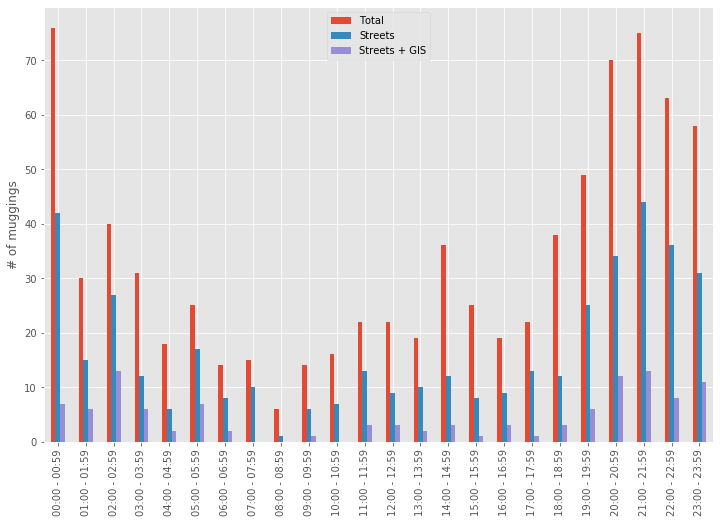

In [25]:
ax = reg_time_df.plot(kind='bar', figsize=((12,8)))
#ax.set_xlabel('Time of the day')
ax.set_ylabel('# of muggings')

In [26]:
reg_time_df['Total (%)'] = reg_time_df['Total']*100 / sum(reg_time_df['Total'])
reg_time_df['Streets (%)'] = reg_time_df['Streets']*100 / sum(reg_time_df['Streets'])
reg_time_df['Streets + GIS (%)'] = reg_time_df['Streets + GIS']*100 / sum(reg_time_df['Streets + GIS'])

In [27]:
reg_time_df

,Total,Streets,Streets + GIS,Total (%),Streets (%),Streets + GIS (%)
00:00 - 00:59,76.0,42.0,7.0,9.464508,10.319410,6.194690
01:00 - 01:59,30.0,15.0,6.0,3.735990,3.685504,5.309735
02:00 - 02:59,40.0,27.0,13.0,4.981320,6.633907,11.504425
03:00 - 03:59,31.0,12.0,6.0,3.860523,2.948403,5.309735
04:00 - 04:59,18.0,6.0,2.0,2.241594,1.474201,1.769912
05:00 - 05:59,25.0,17.0,7.0,3.113325,4.176904,6.194690
06:00 - 06:59,14.0,8.0,2.0,1.743462,1.965602,1.769912
07:00 - 07:59,15.0,10.0,0.0,1.867995,2.457002,0.000000
08:00 - 08:59,6.0,1.0,0.0,0.747198,0.245700,0.000000
09:00 - 09:59,14.0,6.0,1.0,1.743462,1.474201,0.884956


Text(0, 0.5, '% of muggings')

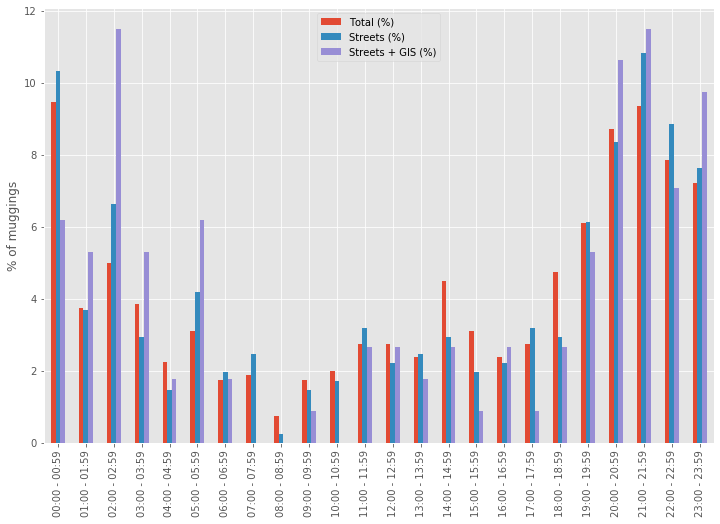

In [28]:
ax = reg_time_df[['Total (%)', 'Streets (%)', 'Streets + GIS (%)']].plot(kind='bar', figsize=((12,8)))
#ax.set_xlabel('Time of the day')
ax.set_ylabel('% of muggings')

Text(0, 0.5, '# of muggings')

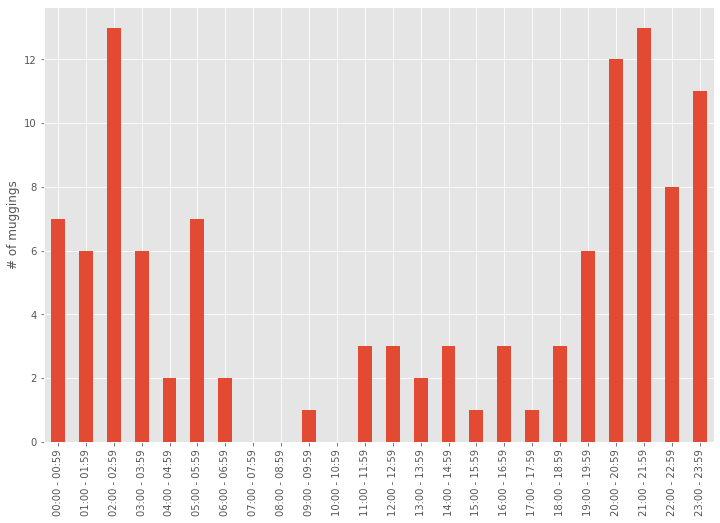

In [29]:
ax = reg_time_df['Streets + GIS'].plot(kind='bar', figsize=((12,8)))
#ax.set_xlabel('Time of the day')
ax.set_ylabel('# of muggings')

In [30]:
time_hist = pd.Series(reg_time_df['Streets + GIS'])
#time_hist['Label'] = reg_time_df.index
time_hist.reset_index(inplace=True, drop=True)

In [31]:
time_hist_2h = pd.Series([time_hist[i]+time_hist[i+1] for i in np.arange(0, 23, 2)], 
                         index=['00:00-01:59', '02:00-03:59', '04:00-05:59', '06:00-07:59', '08:00-09:59', 
                                '10:00-11:59', '12:00-13:59', '14:00-15:59', '16:00-17:59', '18:00-19:59', 
                                '20:00-21:59', '22:00-23:59'])

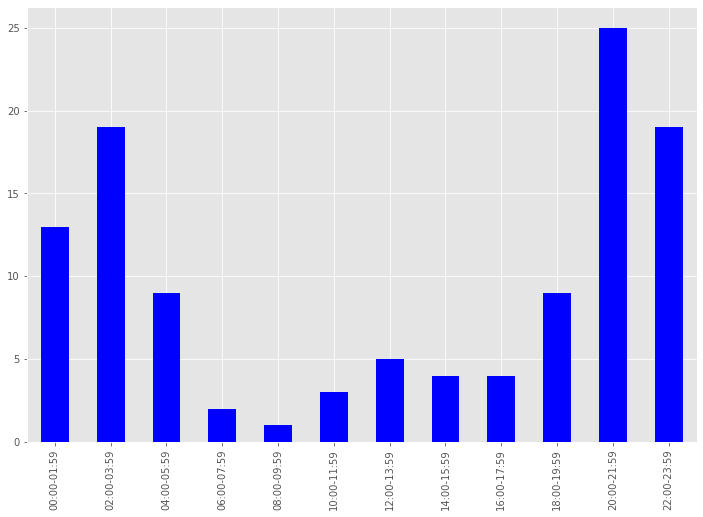

In [32]:
time_hist_2h.plot(kind='bar', figsize=((12,8)), color='blue', )

In [33]:
# Array used in the netlogo code for the variable 
# crime-rates-per-hour [13, 13, 19, 19, 9, 9, 2, 2, 1, 1, 3, 3, 5, 5, 4, 4, 4, 4, 9, 9, 25, 25, 19, 19]
list(time_hist_2h)

[13.0, 19.0, 9.0, 2.0, 1.0, 3.0, 5.0, 4.0, 4.0, 9.0, 25.0, 19.0]